In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')
# pd.set_option('display.max_rows', None)

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [4]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [5]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [6]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수

In [7]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [8]:
#train["법정동_세대수"]=(train.총인구수/train.세대당_인구)/train.총세대수
#test["법정동_세대수"]=(test.총인구수/test.세대당_인구)/test.총세대수

# 자격유형

In [9]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [10]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [11]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [12]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [13]:
train.shape, test.shape

((2577, 38), (936, 37))

# 임대보증금비

In [14]:
#train["임대비율"]=train.임대보증금/train.임대료
#test["임대비율"]=test.임대보증금/test.임대료

# 1차원

In [29]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '자격유형_카테고리'],
      dtype='object')

In [30]:
len(set(train.단지코드))

414

In [31]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [32]:
data.shape

(414, 30)

In [33]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구임대,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [34]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [35]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [36]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,877964.187248,1.038396e+07
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [37]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [38]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [39]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [40]:
data=data.fillna(0)

In [41]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [42]:
data=pd.merge(data, sample, on="단지코드", how="inner")

# Test에 똑같이

In [43]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 29)

In [44]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [45]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [46]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수'] #전용면적별세대수
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [47]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,1.158750e+05,2.265000e+07
1,C1006,2.333169e+06,1.754953e+07
2,C1016,2.280100e+05,2.402675e+07
3,C1019,1.264300e+05,1.485750e+07
4,C1030,2.142167e+05,5.141333e+07


In [48]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [49]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [50]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [51]:
dat=dat.fillna(0)

In [52]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [53]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [54]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',        '상가비율',  '세대당_가능주차면수',
             '공가수비율',        '행복주택',        '영구임대',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',            '자격유형2',            '자격유형7',
                  '자격유형1',             '자격유형6',             '자격유형3',            '자격유형5',
             '대형전용면적']

In [55]:
data.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',        '상가비율',
        '세대당_가능주차면수',       '공가수비율',        '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',        '장기전세',        '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금',             '자격유형1',             '자격유형2',            '자격유형7',
                   '자격유형3',           '자격유형6',             '자격유형4',            '자격유형5',
            '대형전용면적']

# 전용면적 추가

In [56]:
#sample1=pd.DataFrame(train.groupby("단지코드")["전용면적"].mean()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data.head()
#sample1=pd.DataFrame(test.groupby("단지코드")["전용면적"].mean()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat.head()

# 지역 카테고리 추가 & 지역 drop

In [57]:
#group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
#group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']    
#data.loc[data.지역.isin(group1),"지역_카테고리"] = "high"
#data.loc[data.지역.isin(group2),"지역_카테고리"] = "low"
#dat.loc[dat.지역.isin(group1),"지역_카테고리"] = "high"
#dat.loc[dat.지역.isin(group2),"지역_카테고리"] = "low"

# 임대료, 임대보증금 std

In [58]:
#sample1=pd.DataFrame(train.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["임대보증금"].std()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#sample1=pd.DataFrame(test.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["임대보증금"].std()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")

# Correlation 확인

In [59]:
X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역"])

In [60]:
X_cor = pd.get_dummies(X_cor, drop_first=True)

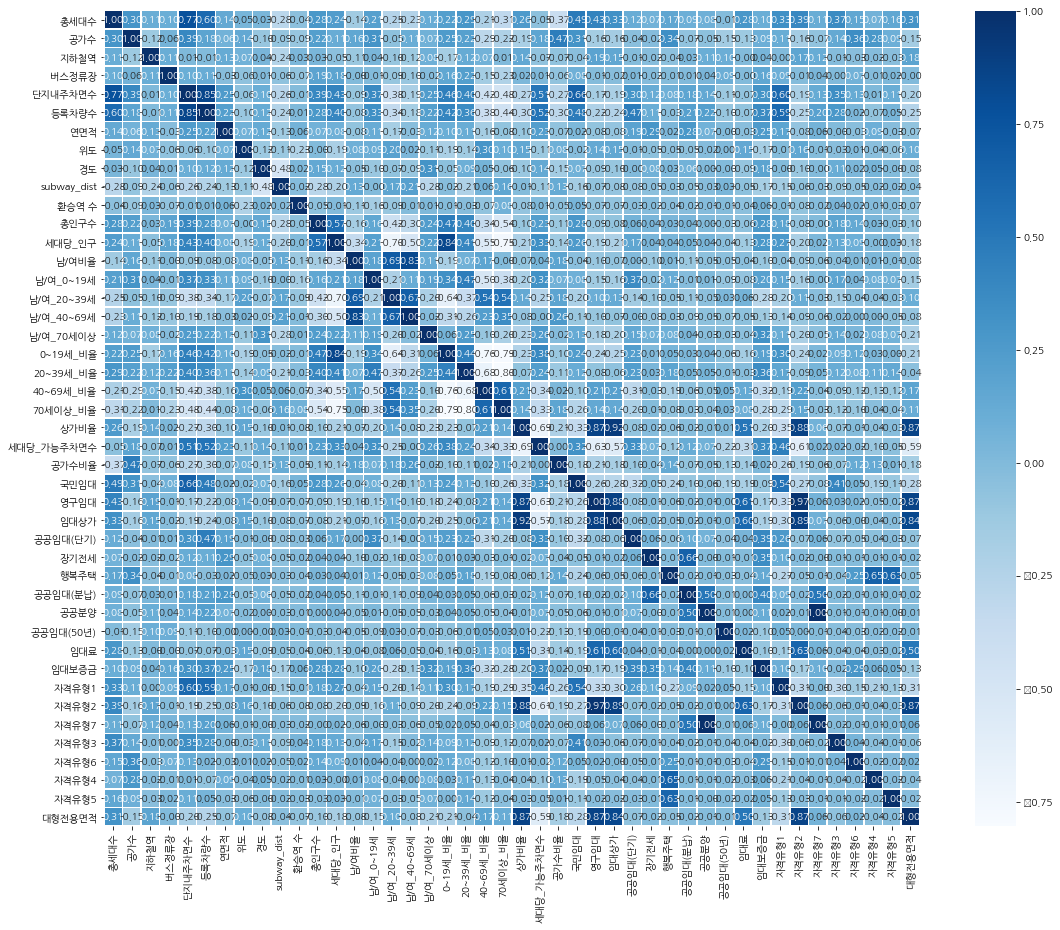

In [61]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [62]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
#from statsmodels.api import OLS

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()
#standardScaler.fit(X_train)
#X_train = standardScaler.transform(X_train)
#standardScaler.fit(X_test)
#X_test = standardScaler.transform(X_test)

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [63]:
train1=data[data.단지내주차면수<785].reset_index(drop=True)
train2=data[data.단지내주차면수>=785].reset_index(drop=True)
test1=dat[dat.단지내주차면수<785].reset_index(drop=True)
test2=dat[dat.단지내주차면수>=785].reset_index(drop=True)

In [64]:
print(test1.shape)
print(test2.shape)

(113, 46)
(34, 46)


In [65]:
X = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)
y = train1['등록차량수']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train, y_train)
model1_pred = model_1.predict(X_test)

In [67]:
print(mean_absolute_error(model1_pred,y_test))

99.77337372373363


In [68]:
prediction = pd.DataFrame(columns=['단지코드','등록차량수','y_pred'])
prediction['단지코드'] = train1.loc[X_test.index.values,'단지코드']
prediction['등록차량수'] = train1.loc[X_test.index.values,'등록차량수']
prediction['y_pred'] = model1_pred
prediction['mae'] = prediction.apply(lambda x : x['y_pred']-x['등록차량수'], axis=1)
prediction['score'] = prediction['mae'].apply(lambda x : 1 if abs(x)<=150 else 0) #0 나쁜 성적
prediction['세대당_인구'] = train1.loc[X_test.index.values,'세대당_인구']

In [69]:
X = train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)
y = train2['등록차량수']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

model_2=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train, y_train)
model2_pred = model_2.predict(X_test)

In [71]:
print(mean_absolute_error(model2_pred,y_test))

281.41337367977025


In [72]:
prediction2 = pd.DataFrame(columns=['단지코드','등록차량수','y_pred'])
prediction2['단지코드'] = train2.loc[X_test.index.values,'단지코드']
prediction2['등록차량수'] = train2.loc[X_test.index.values,'등록차량수']
prediction2['y_pred'] = model2_pred
prediction2['mae'] = prediction2.apply(lambda x : x['y_pred']-x['등록차량수'], axis=1)
prediction2['score'] = prediction2['mae'].apply(lambda x : 1 if abs(x)<=150 else 0) #0 나쁜 성적
prediction2['세대당_인구'] = train2.loc[X_test.index.values,'세대당_인구']

In [302]:
tmp = pd.concat([prediction,prediction2],axis=0)

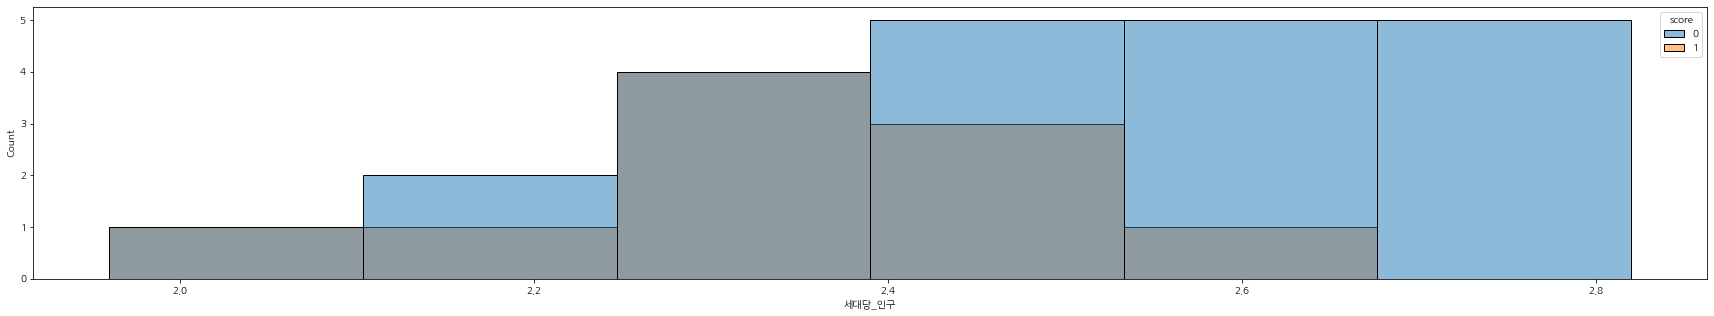

In [303]:
fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=prediction2,x='세대당_인구',hue='score')

In [304]:
print(prediction2[prediction2['세대당_인구']>=2.4]['score'].value_counts())
print(prediction2[prediction2['세대당_인구']<2.4]['score'].value_counts())

0    14
1     4
Name: score, dtype: int64
0    8
1    6
Name: score, dtype: int64


In [307]:
prediction2[prediction2['세대당_인구']>=2.4]

,단지코드,등록차량수,y_pred,mae,score,세대당_인구
2,C1032,316.0,994.668814,678.668814,0,2.590000
46,C1406,1350.0,1249.568491,-100.431509,1,2.420000
4,C1672,873.0,1214.518657,341.518657,0,2.463333
80,C2612,1832.0,1119.650223,-712.349777,0,2.730000
22,C2032,1162.0,900.548262,-261.451738,0,2.770000
13,C2000,795.0,1051.986950,256.986950,0,2.440000
58,C1740,979.0,1638.404978,659.404978,0,2.540000
64,C2373,800.0,880.264688,80.264688,1,2.630000
67,C1649,1214.0,1123.496261,-90.503739,1,2.520000
30,C1579,1158.0,894.507153,-263.492847,0,2.550000


## 나눠서 modeling

# 나눠서 예측

In [95]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,780.832339
1,C1128,1170.293554
2,C1456,586.488892
3,C1840,515.966300
4,C1332,1205.598431


In [96]:
sample.shape

(150, 2)

In [75]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [76]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 49) (104, 49)
(113, 46) (34, 46)


In [77]:
df= pd.concat([train1, test1])
print(train1.shape)
print(test1.shape)
print(df.shape)

(310, 49)
(113, 46)
(423, 49)


In [78]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)

In [79]:
X_train1=X.iloc[0:310, :]
X_test1=X.iloc[310:, :]
y_train1 = train1[['등록차량수']]

In [80]:
X_train1.columns

Index(['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가수비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도'],
      dtype='object')

In [81]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [82]:
model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train1, y_train1)
model1_pred = model_1.predict(X_test1)

In [83]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [84]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1.head()

,code,num
0,C1072,753.207584
1,C1456,535.777826
2,C1840,530.437601
3,C1640,432.556432
4,C1377,381.268094


In [85]:
df= pd.concat([train2, test2])

In [86]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', '임대상가',
                    "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"]) 
X = pd.get_dummies(X, drop_first=True)

In [87]:
X_train2=X.iloc[0:104, :]
X_test2=X.iloc[104:, :]
y_train2 = train2[['등록차량수']]

In [88]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [89]:
model_2= CatBoostRegressor(random_state=2021, verbose=False).fit(X_train2, y_train2)
model2_pred = model_2.predict(X_test2)

In [90]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [91]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2.head()

,code,num
0,C1128,1175.336108
1,C1332,1197.060412
2,C1563,1753.338286
3,C1794,909.721514
4,C2411,796.487139


In [92]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [93]:
df_merge.head()

,code,num
0,C1072,753.207584
1,C1456,535.777826
2,C1840,530.437601
3,C1640,432.556432
4,C1377,381.268094


In [97]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [98]:
test_split.head()

,code,num_x,num_y
0,C1072,780.832339,753.207584
1,C1128,1170.293554,1175.336108
2,C1456,586.488892,535.777826
3,C1840,515.966300,530.437601
4,C1332,1205.598431,1197.060412


In [99]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [100]:
test_split.head()

,code,num
0,C1072,753.207584
1,C1128,1175.336108
2,C1456,535.777826
3,C1840,530.437601
4,C1332,1197.060412


In [101]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [102]:
# one=pd.read_csv("0719_1.csv")
# one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]
# test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]
# mean_absolute_error(one.num, test_.num)

Text(0.5, 0, 'CatBoost1 Feature Importance')

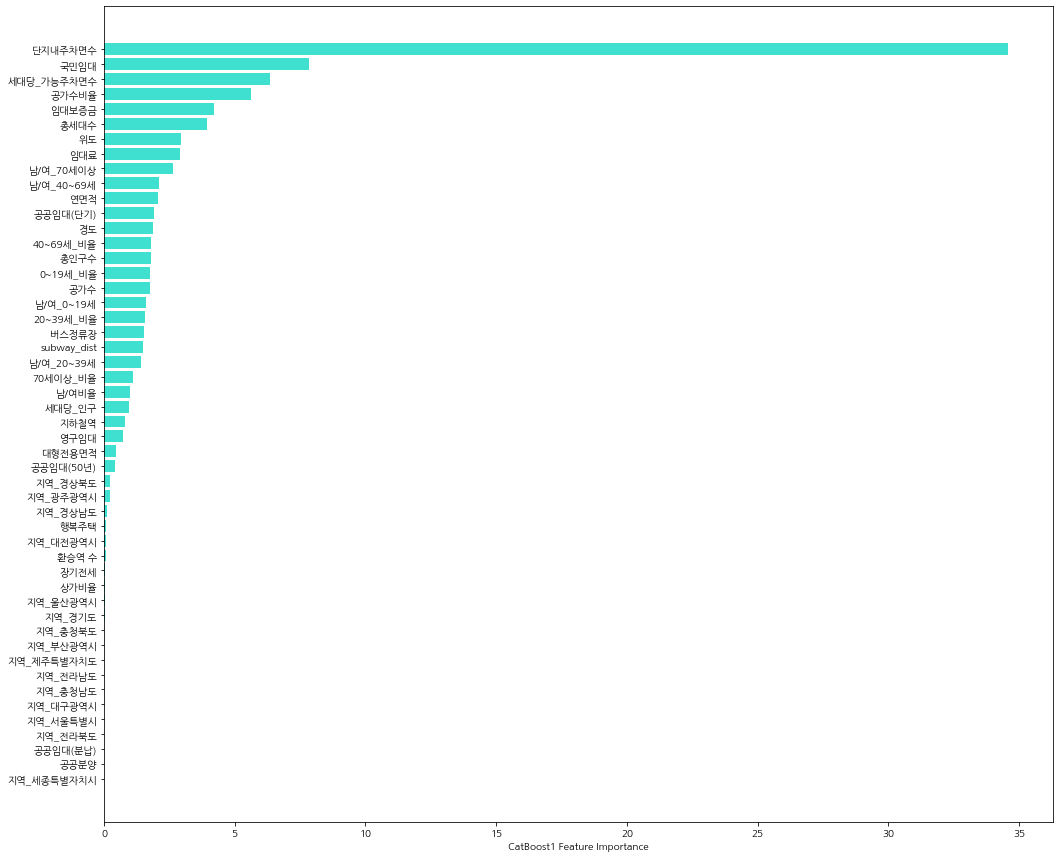

In [103]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X_test1.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost1 Feature Importance")

Text(0.5, 0, 'CatBoost2 Feature Importance')

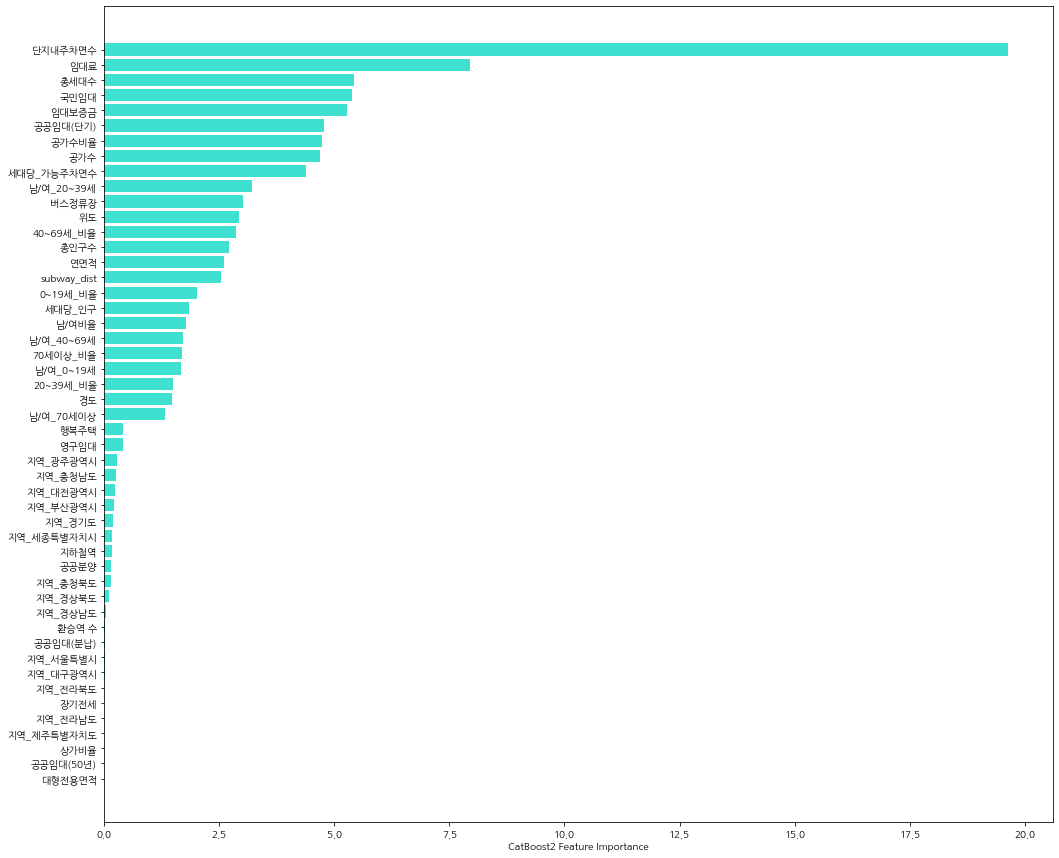

In [104]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_2.feature_importances_.argsort()
plt.barh(X_test2.columns[sorted_feature_importance], 
        model_2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost2 Feature Importance")

In [152]:
# test_split.to_csv('0719_전용.csv', index=False)